# Modelo de redes neuronales convolucionales para la verificación de edades de clientes en la cadena de supermercados Good Seed

<h1>Tabla de Contenidos<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introducción" data-toc-modified-id="Introducción-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introducción</a></span><ul class="toc-item"><li><span><a href="#Objetivos" data-toc-modified-id="Objetivos-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Objetivos</a></span></li></ul></li><li><span><a href="#Inicialización" data-toc-modified-id="Inicialización-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Inicialización</a></span></li><li><span><a href="#Cargar-los-datos" data-toc-modified-id="Cargar-los-datos-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cargar los datos</a></span><ul class="toc-item"><li><span><a href="#Conclusiones" data-toc-modified-id="Conclusiones-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Conclusiones</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Conclusiones" data-toc-modified-id="Conclusiones-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Conclusiones</a></span></li></ul></li><li><span><a href="#Modelado" data-toc-modified-id="Modelado-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelado</a></span></li><li><span><a href="#Script-para-plataforma-GPU" data-toc-modified-id="Script-para-plataforma-GPU-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Script para plataforma GPU</a></span><ul class="toc-item"><li><span><a href="#El-resultado" data-toc-modified-id="El-resultado-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>El resultado</a></span></li></ul></li><li><span><a href="#Conclusiones" data-toc-modified-id="Conclusiones-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusiones</a></span></li></ul></div>

## Introducción

El uso de métodos computacionales para la generación de modelos de redes neuronales que permitan el reconocimiento de imágenes, vídeos y audios se está volviendo cada vez más común, esto debido a su gran cantidad de aplicaciones. Uno de estas es el análisis facial automatizado, que permite resolver problemas desde la inteligencia de negocios hasta la creación de perfiles de usuario. 

A la cadena de supermercados Good Seed le gustaría explorar la ciencia de datos y sus aplicaciones en reconocimiento facial para el correcto cumplimiento de las leyes sobre consumo de alcohol, asegurándose de no vender alcochol a personas menores de edad. Las tiendas están equipadas con cámaras en el área de pago, las cuales se activan cuando una persona está comprando alcohol. Es así que a través de métodos de visión artificial, se va a determinar la edad de una persona a partir de una foto. Con esta premisa, construiremos y evaluaremos un modelo que verifique la edad de las personas a partir de un conjunto de fotografías de personas que indican su edad. 

### Objetivos

1. Construir y evaluar modelos de redes neuronales convolucionales ResNet50, escogiendo aquel modelo que obtenga un EAM inferior a 7.
2. Establecer si nuestro modelo ayudará a la determinación correcta de la edad de clientes y por tanto a la identificación de menores de edad.
3. Determinar si el supermercado Good Seed podrá solucionar otras tareas prácticas con nuestro modelo. 

## Inicialización

Iniciamos importando las librerías que utilizaremos para la construcción de nuestro modelo de redes neuronales. En este caso utilizaremos las librerías `Pandas`, `Seaborn`, `Matplotlib` para importar datos y construir gráficos de distribución. Mientras que se utilizará la libería `Tensorflow` para generar nuestro modelo. 

In [1]:
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Establecemos el estilo de los gráficos
plt.style.use('seaborn')

## Cargar los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`:

- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 

Dado que el número de archivos de imágenes es bastante elevado, crearemos un generador con ImageDataGenerator para evitar leer todos los archivos a la vez y generar lotes de 32 imágenes con sus respectivas etiquetas que permitan una carga de datos más dinámica. Guardaremos el conjunto completo de imágenes como `train_gen_flow`.

El archivo de etiquetas lo cargaremos como un archivo CSV habitual a través de la función `read_csv` de pandas y guardaremos estos datos como `labels`.

In [2]:
# Importamos el archivo con etiquetas y lo guardamos en la variable 'labels'
labels = pd.read_csv('/datasets/faces/labels.csv')

# Establecemos la clase ImageDataGenerator()
train_datagen = ImageDataGenerator(rescale=1./255)

# Extraemos los datos de la carpeta con la función flow_from_dataframe
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Una vez importadas nuestras 7591 imágenes y la información de etiquetas vamos a comprobar el tamaño de nuestro dataset `labels` y si existen valores ausentes o duplicados. Empezamos llamando al atributo `shape` y los métodos `head` e `info`. 

In [3]:
labels.shape

(7591, 2)

In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Nuestro dataset `labels` contiene dos columnas y 7591 filas. La columna `file_name` lleva el id de cada imagen y `real_age` registra las edades reales de las personas en cada fotografía y esta será nuestro objetivo o valor a ser predicho por nuestro modelo. Tanto el número de imágenes importadas como el número de etiquetas corresponden a 7591. Así mismo, el tipo de datos es el correcto para ambas columnas así que no necesitará un preprocesamiento. 

Ahora revisaremos si no existen valores ausentes o duplicados en nuestro datasets de etiquetas. Llamaremos a los métodos `isna` y `duplicated`. 

In [6]:
print(f'''Número de valores ausentes en labels:
{labels.isna().sum()}''')

Número de valores ausentes en labels:
file_name    0
real_age     0
dtype: int64


In [7]:
print(f'Número de valores duplicados en labels: {labels.duplicated().sum()}')

Número de valores duplicados en labels: 0


No se registran valores ausentes ni duplicados, ahora comprobaremos el tamaño de las 32 imágenes que fueron importadas a través de ImageDataGenerator(). 

In [8]:
# Obtenemos el objetivo y características 
features, target = next(train_gen_flow)

# Comprobamos el tamaño de cada imagen y objetivo
print(f'Tamaño de imágenes/características: {features.shape}')
print(f'Tamaño de objetivo: {target.shape}')

Tamaño de imágenes/características: (32, 224, 224, 3)
Tamaño de objetivo: (32,)


### Conclusiones

1. Se trabajará con un total de 7591 imágenes de tamaño 224x224x3, de las cuales se importó una muestra de 32 imágenes y sus respectivas etiquetas con la información de edad y el id de la imagen a través de un generador ImageDataGenerator. 
2. Al analizar las etiquetas con información de edades no se registraron valores ausentes ni duplicados, a su vez el tipo de datos fue el correcto por lo que no se requerirá un preprocesamiento de datos. 

## EDA

Ahora procederemos a realizar un análisis exploratorio de los datos con los cuales trabajaremos. En el caso de la edad, construiremos gráficos de barras y diagramas de cajas para visualizar mejor la distribución de los datos. Por otro lado, imprimiremos un grupo de fotografías de nuestra muestra inicial de 32 imágenes y las analizaremos. 

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


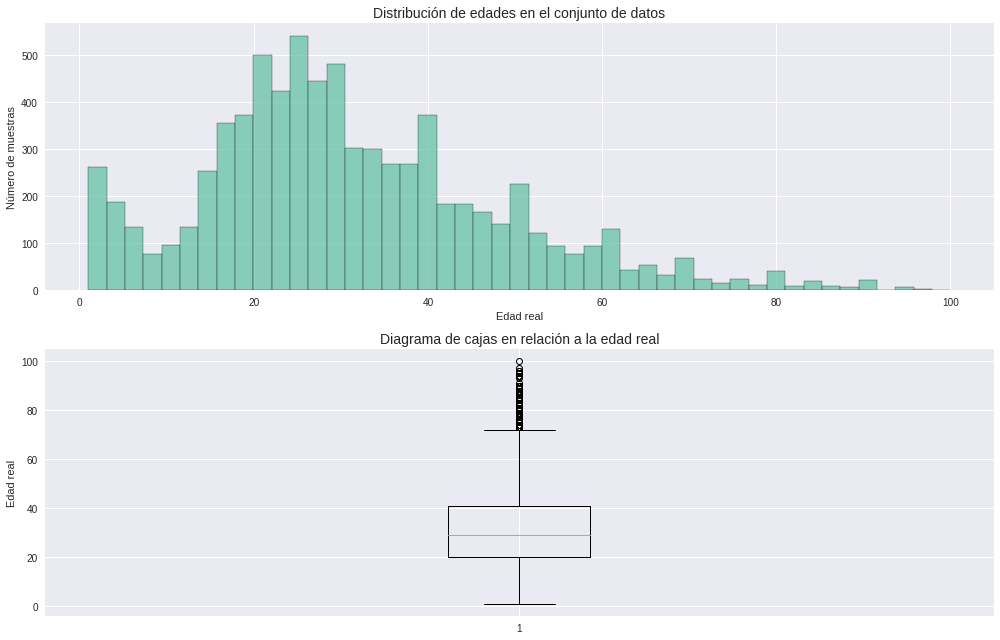

In [9]:
# Imprimimos métricas descriptivas para entender mejor la distribución de nuestros datos
print(labels.describe())

# Generamos subplots para visualización de datos
fig, axs = plt.subplots(2, 1, figsize=(14, 9))
sns.set_palette('Set2')

# En el primer subplot trazaremos un gráfico de barras a través de histplot de la librería seaborn
ax1 = axs[0]
sns.histplot(labels, x='real_age', ax=ax1)
ax1.set_title('Distribución de edades en el conjunto de datos', fontsize=14)
ax1.set_xlabel('Edad real')
ax1.set_ylabel('Número de muestras')

# En el segundo subplot construiremos un diagrama de cajas a partir de la función boxplot. 
ax2 = axs[1]
ax2.boxplot(labels['real_age'])
ax2.set_title('Diagrama de cajas en relación a la edad real', fontsize=14)
ax2.set_ylabel('Edad real')

# Establecemos un output más compacto
fig.tight_layout()

Nos encontramos con edades dentro de un rango de 1 a 100 años, con un promedio de 31 y una mediana de 29, lo cual indica una asimetría positiva en nuestros datos. Esto se puede corroborar en el gráfico de barras, en este se registra un sesgo hacia la derecha con una mayor cantidad de información de adultos jóvenes entre los 20 a 40 años. A partir de los 60 años se pueden observar una menor número de muestras con valores inferiores a 100. Podríamos relacionar este comportamiento de nuestro datos a que las fotografías fueron colectadas desde repositorios de Internet, lo cual disminuye las muestras registradas para adultos mayores. 

En nuestro diagrama de cajas se vuelve a comprobar que la mayoría de datos se centran entre los 20 a 40 años, valores que corresponden al cuartil 1 y cuartil 3 respectivamente. Después de los 70 años se puede observar la presencia de valores atípicos, que como se mencionó anteriormente, corresponden a adultos mayores. No vamos a procesar estos valores ya que se perderá información valiosa para la construcción de nuestro modelo de redes neuronales. 

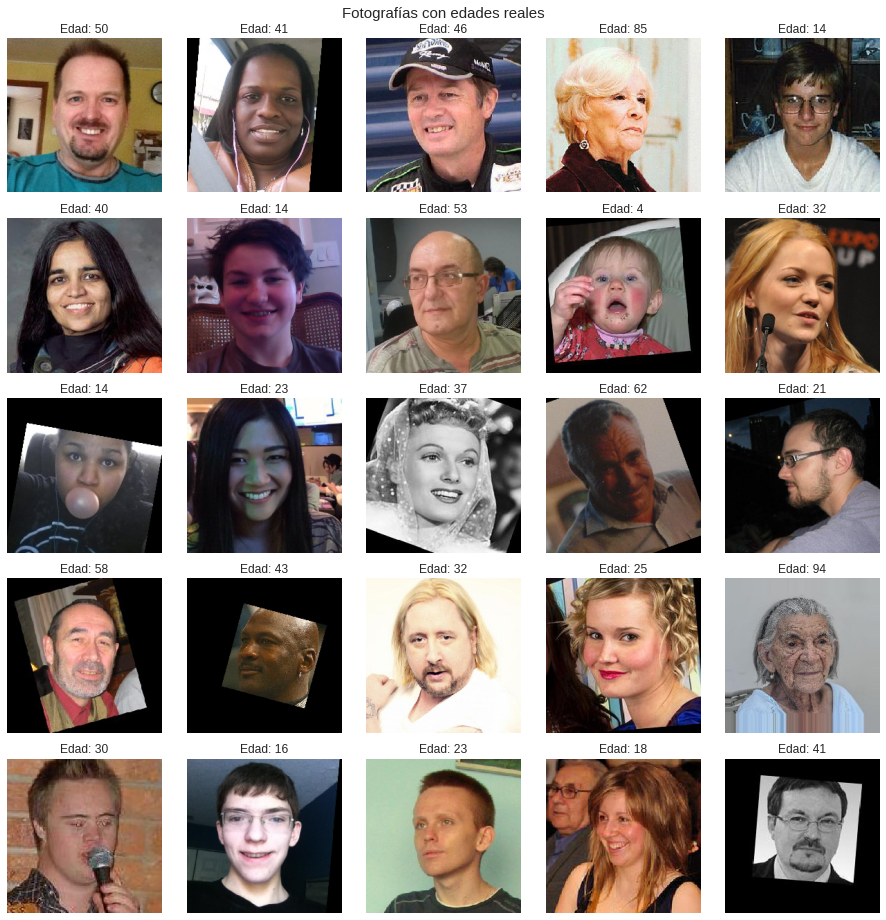

In [10]:
# Establecemos el tamaño de la figura
fig = plt.figure(figsize=(13,13))

# Construimos un bucle que devolverá 25 imágenes con sus edades reales respectivas
for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title(f'Edad: {target[i]}')
    # quitamos los ejes y colocamos las imágenes cerca para obtener un output más compacto
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Fotografías con edades reales', fontsize=15)
    plt.tight_layout()

Al analizar una muestra de 25 imágenes observamos fotografías dentro de un rango de edad de 4 a 94 años, comprobando lo establecido anteriormente, existe mayor número de observaciones o muestras de adultos jóvenes, mientras que apenas existen dos fotografías de adultos mayores. 

Siete fotografías han sido encuadradas en el rostro de la persona, esto ayudará al modelo a detectar mejor los rasgos o características faciales que distiguen a cada edad. Sin embargo, muchas de estas fotografías presentan una leve rotación, así que será necesario aplicar un aumento de rotación antes de entrenar nuestro modelo. A su vez, en las 18 fotografías restantes existen otros elementos, como personas en el fondo, que pueden generar ruido y afectar la detección de edades, así que aplicaremos un aumento vertical y horizontal en las fotografías. 

Existen otros componentes que afectarán la calidad de reconocimiento facial de nuestro modelo, por ejemplo, la presencia de ciertos artefactos como micrófonos, gomas de mascar o lentes. Así mismo, ciertas fotografías solo nos muestran el perfil de la persona, esto dificultará la correcta detección de edades.  

### Conclusiones

1. Nuestra base de datos fotográficos presenta muestras que varían desde los 1 a los 100 años de edad. Con una mayor cantidad de información para adultos jóvenes entre los 20 a 40 años de edad, mientras que para adultos mayores existe una disminución del número de muestras, esto puede estar asociado a que las fotografías se obtuvieron de internet, siendo más fácil encontrar información de personas jóvenes que tienen mejores habilidades en informática. 
2. En una muestra de 25 imagénes se observaron ciertos elementos como ruido de fondo o arfetactos que pueden confundir al modelo y disminuir su rendimiento. Es así que se realizarán aumentos como reflejo horizontal, rotaciones y aumentos verticales y horizontales que aumentarán la calidad de detección de edades. 

## Modelado

Para la construcción de modelos vamos a definir cuatro funciones que posteriormente serán procesadas en una plataforma GPU para un rápido entrenamiento y evaluación de modelos. Las dos primeras funciones `load_train` y `load_test` cargarán el conjunto de entrenamiento y prueba/validación a través de una clase ImageDataGenerator. Estos se dividirán en una proporción 75:25. 

La tercera función `create_model` va a definir el tipo de modelo de redes neuronales que utilizaremos. En este caso construiremos un modelo de redes neuronales convolucionales ResNet50, que utiliza 50 capas de profundidad además de un bypass o un salto que pasa por alto dos capas sucesivas a gran escala, de esta manera la red aprende de forma representativa las características de las imágenes. Acepta imágenes de tamaño 224x224 como lo son las fotografías de nuestra base de datos. 

El modelo que construiremos es de regresión ya que buscamos predecir la edad de personas en base a fotografías, así que utilizaremos una sola capa de salida con una función de activación `relu`. Por otro lado, utilizaremos el `ECM` error cuadrático medio como métrica para determinar la función de pérdida y `EAM` error absoluto medio como métrica de evalución final del modelo. A su vez, optimizaremos la función de pérdida a través del algoritmo `Adam` con una tasa de aprendizaje de 0.0001. 

Por último, estableceremos la función `train_model` que nos permitirá entrenar el modelo y evaluarlo en el conjunto de validación/prueba a través de 20 épocas. 

Vamos a entrenar dos modelos:

- **Modelo 1**: este no presentará ningún tipo de aumento y solo contará con capas convolucionales ResNet50, una capa de GlobalAveragePooling y una capa de salida con una unidad y función de activación relu. Nos servirá para establecer un valor de referencia de EAM. 

- **Modelo 2**: se entrenará con capas convolucionales ResNet50, una capa de GlobalAveragePooling, dos capas Dropout de 0.20 y una capa de salida de una unidad. Este modelo presentará un solo aumento: horizontal_flip. 

- **Modelo 3**: se entrenará con capas convolucionales ResNet50, una capa de GlobalAveragePooling, una capa Dropout de 0.20 y una capa de salida de una unidad. Este modelo presentará seis tipos de aumentos, lo que incrementará el tamaño del conjunto de entrenamiento y por tanto la calidad del modelo:
    - horizontal_flip: reflejo horizontal
    - shear_range: se distorsionará la imagen para obtener diferentes ángulos, considerando que varias imágenes presentaban a personas de perfil. 
    - zoom_range: se realizará un zoom en la imagen para quitar artefactos en el fondo que puedan confundir al modelo. 
    - height_shift_range: mueve la imagen a lo largo de un eje vertical.
    - width_shift_range: mueve la imagen a lo largo de un eje horizontal.
    - rotation_range: ángulo de rotación.

A continuación se presentan las cuatro funciones utilizadas y se presentan como comentarios los hiperparámetros del segundo y tercer modelo. 

In [11]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    
    :path: ruta de ubicación de los archivos
    
    """
    labels = pd.read_csv(path + 'labels.csv')
    
    #modelo 1
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1.0 / 255, 
                                       )
    #modelo 2
    #train_datagen = ImageDataGenerator(validation_split=0.25, 
    #                                   rescale=1.0 / 255,
    #                                   horizontal_flip=True,
    #                                   )

    #modelo3
    #train_datagen = ImageDataGenerator(validation_split=0.25, 
    #                                   rescale=1.0 / 255,
    #                                   horizontal_flip=True,
    #                                   shear_range=0.2,
    #                                   zoom_range=0.2,
    #                                   height_shift_range=0.1,
    #                                   width_shift_range=0.1,
    #                                   rotation_range=15
    #                                   )

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 

    return train_gen_flow

In [12]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    
    :path: ruta de ubicacion de los archivos
    
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, 
                                      rescale=1.0 / 255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 

    return test_gen_flow

In [13]:
def create_model(input_shape):
    
    """
    Define el modelo
    
    :input_shape: tamaño de imágenes en formato (224, 224, 3)
    
    """
    
    backbone = ResNet50(
    input_shape=input_shape, weights='imagenet', include_top=False
    )
    
    #modelo 1
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    #modelo 2
    #model = Sequential()
    #model.add(backbone)
    #model.add(Dropout(0.20))
    #model.add(GlobalAveragePooling2D())
    #model.add(Dropout(0.20))
    #model.add(Dense(1, activation='relu'))

    #modelo 3
    #model = Sequential()
    #model.add(backbone)
    #model.add(GlobalAveragePooling2D())
    #model.add(Dropout(0.20))
    #model.add(Dense(1, activation='relu')) 
    
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(
    loss='mean_squared_error', optimizer=optimizer, metrics=['mae']
    )
    
    return model

In [14]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    
    :model: model a ser entrenado
    :train_data: conjunto de datos para el entrenamiento
    :test_data: conjunto de datos para prueba
    :batch_size: número de muestras procesadas
    :epochs: número de épocas por las que pasará el conjunto
    :steps_per_epoch: número de pasos entrenamiento
    :validation_steps: número de pasos validación
    
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 

    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2)

    return model

##  Script para plataforma GPU

Como se mencionó anteriormente los modelos fueron procesados en una plataforma con acceso a GPU para que el tiempo de entrenamiento sea menor. A continuación se presenta el script utilizado para el tercer modelo con aumentos. 

In [15]:
# Script para plataforma GPU

init_str = """

import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                      rescale=1.0 / 255,
                                      horizontal_flip=True,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      height_shift_range=0.1,
                                      width_shift_range=0.1,
                                      rotation_range=15
                                       )
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 

    return train_gen_flow
    
def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, 
                                      rescale=1.0 / 255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 

    return test_gen_flow
    
def create_model(input_shape):
    
    backbone = ResNet50(
    input_shape=input_shape, weights='imagenet', include_top=False
    )
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.20))
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(
    loss='mean_squared_error', optimizer=optimizer, metrics=['mae']
    )
    
    return model
    
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 

    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2)

    return model

"""

# Descargamos el script con formato py para procesarlo en GPU
with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

Los valores de la métrica EAM por cada época se presentan como comentarios. A partir de estos resultados se trazaron gráficos de líneas para visualizar mejor los cambios generados en nuestra métrica a lo largo de las diferentes épocas.  

**MODELO 1**
<br>
<br>
Epoch 1/20
<br>
178/178 - 89s - loss: 281.0445 - mae: 11.9985 - val_loss: 656.7921 - val_mae: 20.6876
<br>
Epoch 2/20
<br>
178/178 - 72s - loss: 70.5169 - mae: 6.3838 - val_loss: 557.9674 - val_mae: 18.4533
<br>
Epoch 3/20
<br>
178/178 - 72s - loss: 34.7438 - mae: 4.5335 - val_loss: 212.2598 - val_mae: 11.0318
<br>
Epoch 4/20
<br>
178/178 - 72s - loss: 22.7191 - mae: 3.6626 - val_loss: 146.5900 - val_mae: 9.6866
<br>
Epoch 5/20
<br>
178/178 - 72s - loss: 19.0211 - mae: 3.3541 - val_loss: 83.6946 - val_mae: 6.8666
<br>
Epoch 6/20
<br>
178/178 - 72s - loss: 17.4460 - mae: 3.2441 - val_loss: 96.1507 - val_mae: 7.6717
<br>
Epoch 7/20
<br>
178/178 - 72s - loss: 17.0593 - mae: 3.2060 - val_loss: 71.3902 - val_mae: 6.4537
<br>
Epoch 8/20
<br>
178/178 - 72s - loss: 15.2663 - mae: 3.0087 - val_loss: 77.5606 - val_mae: 6.5776
<br>
Epoch 9/20
<br>
178/178 - 72s - loss: 14.3434 - mae: 2.9144 - val_loss: 70.1241 - val_mae: 6.4091
<br>
Epoch 10/20
<br>
178/178 - 72s - loss: 13.6657 - mae: 2.8401 - val_loss: 83.6464 - val_mae: 7.1057
<br>
Epoch 11/20
<br>
178/178 - 72s - loss: 12.3405 - mae: 2.7080 - val_loss: 79.8844 - val_mae: 6.6938
<br>
Epoch 12/20
<br>
178/178 - 72s - loss: 10.9629 - mae: 2.5191 - val_loss: 65.6516 - val_mae: 6.0846
<br>
Epoch 13/20
<br>
178/178 - 72s - loss: 12.0532 - mae: 2.6971 - val_loss: 68.8434 - val_mae: 6.1467
<br>
Epoch 14/20
<br>
178/178 - 72s - loss: 10.1120 - mae: 2.4588 - val_loss: 74.6470 - val_mae: 6.5458
<br>
Epoch 15/20
<br>
178/178 - 72s - loss: 12.2417 - mae: 2.6434 - val_loss: 66.8770 - val_mae: 6.0503
<br>
Epoch 16/20
<br>
178/178 - 72s - loss: 10.3671 - mae: 2.4362 - val_loss: 125.8691 - val_mae: 9.0231
<br>
Epoch 17/20
<br>
178/178 - 72s - loss: 9.6479 - mae: 2.3857 - val_loss: 76.5631 - val_mae: 6.4095
<br>
Epoch 18/20
<br>
178/178 - 72s - loss: 9.0027 - mae: 2.2835 - val_loss: 70.4400 - val_mae: 6.2388
<br>
Epoch 19/20
<br>
178/178 - 72s - loss: 6.5308 - mae: 1.9703 - val_loss: 66.8204 - val_mae: 6.3193
<br>
Epoch 20/20
<br>
178/178 - 72s - loss: 6.5824 - mae: 1.9809 - val_loss: 71.6788 - val_mae: 6.5942  


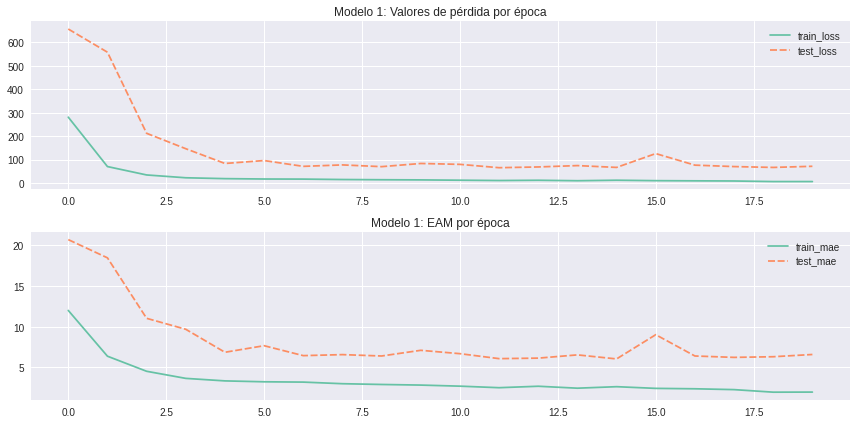

In [16]:
metrics_model_1 =  pd.DataFrame(
    {'train_loss': [281.0445, 70.5169, 34.7438, 22.7191, 19.0211, 17.4460, 17.0593, 15.2663, 14.3434, 13.6657,
                   12.3405, 10.9629, 12.0532, 10.1120, 12.2417, 10.3671, 9.6479, 9.0027, 6.5308, 6.5824],
     'train_mae' : [11.9985, 6.3838, 4.5335, 3.6626, 3.3541, 3.2441, 3.2060, 3.0087, 2.9144, 2.8401,
                   2.7080, 2.5191, 2.6971, 2.4588, 2.6434, 2.4362, 2.3857, 2.2835, 1.9703, 1.9809],
     'test_loss' : [656.7921, 557.9674, 212.2598, 146.5900, 83.6946, 96.1507, 71.3902, 77.5606, 70.1241, 83.6464,
                   79.8844, 65.6516, 68.8434, 74.6470, 66.8770, 125.8691, 76.5631, 70.4400, 66.8204, 71.6788],
     'test_mae'  : [20.6876, 18.4533, 11.0318, 9.6866, 6.8666, 7.6717, 6.4537, 6.5776, 6.4091, 7.1057,
                   6.6938, 6.0846, 6.1467, 6.5458, 6.0503, 9.0231, 6.4095, 6.2388, 6.3193, 6.5942]    
    }

)

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax1 = axs[0]
sns.lineplot(data=metrics_model_1[['train_loss', 'test_loss']], ax=ax1)
ax1.set_title('Modelo 1: Valores de pérdida por época')

ax2 = axs[1]
sns.lineplot(data=metrics_model_1[['train_mae', 'test_mae']], ax=ax2)
ax2.set_title('Modelo 1: EAM por época')

fig.tight_layout()

El valor EAM alcanzado por nuestro modelo 1 sin aumentos fue de 6.59 para el conjunto de prueba y 1.98 para el conjunto de entrenamiento. Si bien la métrica alcanzada es inferior al valor EAM de referencia, se observa un sobreajuste de más de cuatro puntos. Esto se hace más evidente al analizar nuestro gráfico de líneas, registrando una mayor distancia entre ambos conjuntos a medida que avanza el número de épocas, incluso se puede observar un EAM de 9 para la época 15. Esto podría relacionarse a que las redes neuronales con una gran cantidad de capas tienden a sobreajustarse.

**MODELO 2**
<br>
<br>
Epoch 1/20
<br>
178/178 - 85s - loss: 274.5881 - mae: 11.7140 - val_loss: 815.5589 - val_mae: 23.6499 
<br>
Epoch 2/20
<br>
178/178 - 72s - loss: 86.7809 - mae: 6.9641 - val_loss: 688.2826 - val_mae: 21.0740
<br>
Epoch 3/20
<br>
178/178 - 72s - loss: 56.4114 - mae: 5.7129 - val_loss: 185.9632 - val_mae: 10.5636
<br>
Epoch 4/20
<br>
178/178 - 72s - loss: 44.0912 - mae: 5.0012 - val_loss: 109.1717 - val_mae: 7.9554
<br>
Epoch 5/20
<br>
178/178 - 72s - loss: 34.0059 - mae: 4.4912 - val_loss: 86.5926 - val_mae: 7.1368
<br>
Epoch 6/20
<br>
178/178 - 72s - loss: 29.5126 - mae: 4.1525 - val_loss: 67.4277 - val_mae: 6.1266
<br>
Epoch 7/20
<br>
178/178 - 72s - loss: 25.7091 - mae: 3.8163 - val_loss: 91.5541 - val_mae: 7.4418
<br>
Epoch 8/20
<br>
178/178 - 72s - loss: 21.0009 - mae: 3.5144 - val_loss: 71.5924 - val_mae: 6.2737
<br>
Epoch 9/20
<br>
178/178 - 72s - loss: 18.9291 - mae: 3.3285 - val_loss: 66.3297 - val_mae: 6.0313
<br>
Epoch 10/20
<br>
178/178 - 72s - loss: 17.0089 - mae: 3.1731 - val_loss: 78.1119 - val_mae: 6.8135
<br>
Epoch 11/20
<br>
178/178 - 72s - loss: 15.3174 - mae: 3.0219 - val_loss: 81.5410 - val_mae: 7.0090
<br>
Epoch 12/20
<br>
178/178 - 72s - loss: 14.4888 - mae: 2.9293 - val_loss: 66.4725 - val_mae: 6.1289
<br>
Epoch 13/20
<br>
178/178 - 72s - loss: 14.0948 - mae: 2.8755 - val_loss: 81.8079 - val_mae: 7.0550
<br>
Epoch 14/20
<br>
178/178 - 72s - loss: 14.3606 - mae: 2.9130 - val_loss: 60.2261 - val_mae: 5.8277
<br>
Epoch 15/20
<br>
178/178 - 72s - loss: 13.9437 - mae: 2.8711 - val_loss: 63.2935 - val_mae: 5.9493
<br>
Epoch 16/20
<br>
178/178 - 72s - loss: 13.6057 - mae: 2.7766 - val_loss: 73.6026 - val_mae: 6.3786
<br>
Epoch 17/20
<br>
178/178 - 72s - loss: 15.1285 - mae: 2.9885 - val_loss: 66.4714 - val_mae: 6.2234 
<br>
Epoch 18/20
<br>
178/178 - 72s - loss: 12.7779 - mae: 2.7315 - val_loss: 60.6152 - val_mae: 5.6890
<br>
Epoch 19/20
<br>
178/178 - 72s - loss: 10.3881 - mae: 2.4544 - val_loss: 60.7260 - val_mae: 5.8132
<br>
Epoch 20/20
<br>
178/178 - 72s - loss: 10.2819 - mae: 2.4399 - val_loss: 60.8162 - val_mae: 5.7000 

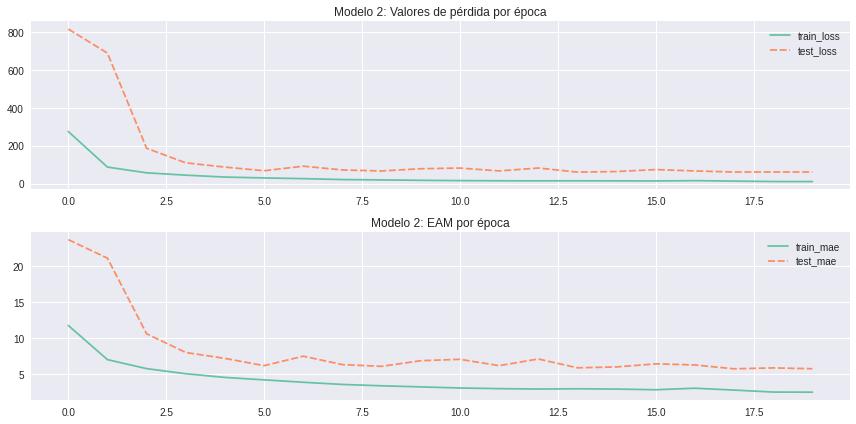

In [17]:
metrics_model_2 =  pd.DataFrame(
    {'train_loss': [274.5881, 86.7809, 56.4114, 44.0912, 34.0059, 29.5126, 25.7091, 21.0009, 18.9291, 17.0089,
                   15.3174, 14.4888, 14.0948, 14.3606, 13.9437, 13.6057, 15.1285, 12.7779, 10.3881, 10.2819],
     'train_mae' : [11.7140, 6.9641, 5.7129, 5.0012, 4.4912, 4.1525, 3.8163, 3.5144, 3.328, 3.17315,  
                   3.0219, 2.9293, 2.8755, 2.9130, 2.8711, 2.7766, 2.9885, 2.7315, 2.4544, 2.4399],
     'test_loss' : [815.5589, 688.2826, 185.9632, 109.1717, 86.5926, 67.4277, 91.5541, 71.5924, 66.3297, 78.1119,
                    81.5410, 66.4725, 81.8079, 60.2261, 63.2935, 73.6026, 66.4714, 60.6152, 60.7260, 60.8162],
     'test_mae'  : [23.6499, 21.0740, 10.5636, 7.9554, 7.1368, 6.1266, 7.4418, 6.2737, 6.0313, 6.8135,
                   7.0090, 6.1289, 7.0550, 5.8277, 5.9493, 6.3786, 6.2234, 5.6890, 5.8132, 5.7000]    
    }

)

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax1 = axs[0]
sns.lineplot(data=metrics_model_2[['train_loss', 'test_loss']], ax=ax1)
ax1.set_title('Modelo 2: Valores de pérdida por época')

ax2 = axs[1]
sns.lineplot(data=metrics_model_2[['train_mae', 'test_mae']], ax=ax2)
ax2.set_title('Modelo 2: EAM por época')

fig.tight_layout()

En nuestro segundo modelo con un aumento se obtuvo un EAM de 5.70 para el conjunto de entrenamiento y 2.43 para el conjunto de prueba. Se observa una mejora en el valor de la métrica obtenido para la última época y una ligera disminución en el sobreajuste del modelo, esto se relacionaría al incremento del tamaño del conjunto de datos al transformar las imágenes existentes con sus reflejos horizontales en el conjunto de entrenamiento. También la aplicación de capas dropout ayuda al sobreajuste, ciertas neuronas son seleccionadas durante el entrenamiento e ignoradas, es decir que no contribuyen a la activación de neuronas de otras capas y la red se vuelve menos sensible al peso específico de ciertas neuronas, generalizando mejor y disminuyendo el sobreajuste. 

**MODELO 3**
<br>
<br>
Epoch 1/20
<br>
178/178 - 133s - loss: 251.3118 - mae: 11.5074 - val_loss: 783.0078 - val_mae: 23.0719
<br>
Epoch 2/20
<br>
178/178 - 112s - loss: 104.0301 - mae: 7.6840 - val_loss: 814.7148 - val_mae: 23.5977 
<br>
Epoch 3/20
<br>
178/178 - 113s - loss: 80.6731 - mae: 6.8216 - val_loss: 385.9045 - val_mae: 15.0232
<br>
Epoch 4/20
<br>
178/178 - 112s - loss: 67.9629 - mae: 6.2944 - val_loss: 122.4760 - val_mae: 8.4160
<br>
Epoch 5/20
<br>
178/178 - 113s - loss: 62.7116 - mae: 6.0744 - val_loss: 137.7855 - val_mae: 8.9794
<br>
Epoch 6/20
<br>
178/178 - 112s - loss: 53.3943 - mae: 5.6154 - val_loss: 102.8859 - val_mae: 7.5167
<br>
Epoch 7/20
<br>
178/178 - 112s - loss: 49.1683 - mae: 5.4015 - val_loss: 71.9905 - val_mae: 6.3400
<br>
Epoch 8/20
<br>
178/178 - 114s - loss: 43.1987 - mae: 5.0682 - val_loss: 71.4092 - val_mae: 6.2045
<br>
Epoch 9/20
<br>
178/178 - 112s - loss: 40.6592 - mae: 4.8612 - val_loss: 72.1136 - val_mae: 6.2587
<br>
Epoch 10/20
<br>
178/178 - 112s - loss: 38.3693 - mae: 4.7605 - val_loss: 99.8239 - val_mae: 7.3616
<br>
Epoch 11/20
<br>
178/178 - 112s - loss: 32.6885 - mae: 4.4151 - val_loss: 69.3964 - val_mae: 6.2263
<br>
Epoch 12/20
<br>
178/178 - 113s - loss: 29.9240 - mae: 4.2341 - val_loss: 73.9857 - val_mae: 6.5223
<br>
Epoch 13/20
<br>
178/178 - 112s - loss: 31.8496 - mae: 4.3588 - val_loss: 79.8721 - val_mae: 6.3913
<br>
Epoch 14/20
<br>
178/178 - 113s - loss: 30.3961 - mae: 4.2758 - val_loss: 66.6401 - val_mae: 6.0393
<br>
Epoch 15/20
<br>
178/178 - 112s - loss: 27.3247 - mae: 4.0386 - val_loss: 61.8362 - val_mae: 5.7831
<br>
Epoch 16/20
<br>
178/178 - 112s - loss: 26.2743 - mae: 3.9379 - val_loss: 74.5985 - val_mae: 6.4586
<br>
Epoch 17/20
<br>
178/178 - 113s - loss: 25.6910 - mae: 3.9030 - val_loss: 66.0779 - val_mae: 6.1350
<br>
Epoch 18/20
<br>
178/178 - 112s - loss: 23.4369 - mae: 3.7659 - val_loss: 71.8205 - val_mae: 6.4987
<br>
Epoch 19/20
<br>
178/178 - 112s - loss: 21.0070 - mae: 3.5360 - val_loss: 64.1421 - val_mae: 5.8841
<br>
Epoch 20/20
<br>
178/178 - 122s - loss: 21.2526 - mae: 3.5648 - val_loss: 60.9427 - val_mae: 5.8039
<br>

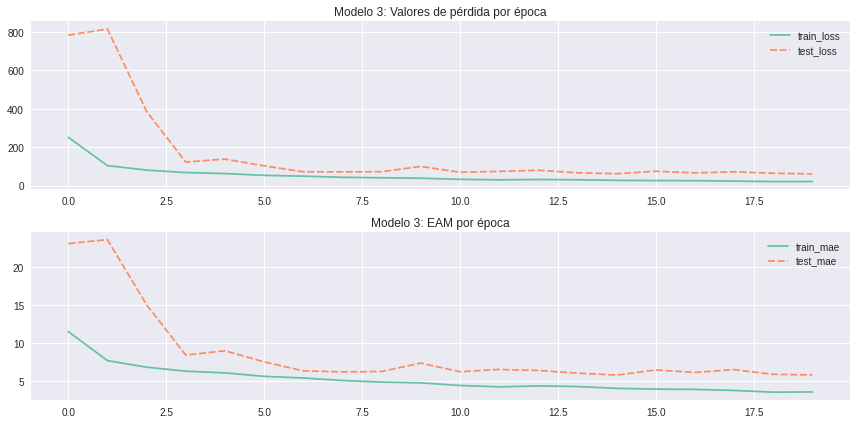

In [19]:
metrics_model_3 =  pd.DataFrame(
    {'train_loss': [251.3118, 104.0301, 80.6731, 67.9629, 62.7116, 53.3943, 49.1683, 43.1987, 40.6592, 38.3693,
                   32.6885, 29.9240, 31.8496, 30.3961, 27.3247, 26.2743, 25.6910, 23.4369, 21.0070, 21.2526],
     'train_mae' : [11.5074, 7.6840, 6.8216, 6.2944, 6.0744, 5.6154, 5.4015, 5.0682, 4.8612, 4.7605,
                   4.4151, 4.2341, 4.3588, 4.2758, 4.0386, 3.9379, 3.9030, 3.7659, 3.5360, 3.5648],
     'test_loss' : [783.0078, 814.7148, 385.9045, 122.4760, 137.7855, 102.8859, 71.9905, 71.4092, 72.1136, 99.8239,
                   69.3964, 73.9857, 79.8721, 66.6401, 61.8362, 74.5985, 66.0779, 71.8205, 64.1421, 60.9427],
     'test_mae'  : [23.0719, 23.5977, 15.0232, 8.4160, 8.9794, 7.5167, 6.3400, 6.2045, 6.2587, 7.3616,
                   6.2263, 6.5223, 6.3913, 6.0393, 5.7831, 6.4586, 6.1350, 6.4987, 5.8841, 5.8039]    
    }

)


fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax1 = axs[0]
sns.lineplot(data=metrics_model_3[['train_loss', 'test_loss']], ax=ax1)
ax1.set_title('Modelo 3: Valores de pérdida por época')

ax2 = axs[1]
sns.lineplot(data=metrics_model_3[['train_mae', 'test_mae']], ax=ax2)
ax2.set_title('Modelo 3: EAM por época')

fig.tight_layout()

En nuestro tercer modelo se alcanzó un EAM de 5.80 para el conjunto de entrenamiento y 3.56 para el conjunto de prueba. Si bien el sobreajuste disminuye considerablemente en comparación con nuestros modelos sin aumentos y con un solo aumento, la métrica EAM no disminuye, más bien incrementa ligeramente. Esto se podría relacionar a que cada aumento implica un incremento en el tamaño de nuestro dataset original y, a su vez la clase y contenido de la imagen puede cambiar, alterando la calidad final del modelo. Quizás utilizar una menor cantidad de aumentos sea más beneficioso para nuestro modelo.   

## Conclusiones

1. Se trabajó con 7591 imágenes de tamaño 224x224x3 que contenían el rostro de personas y sus edades respectivas. No se registraron valores ausentes, duplicados o tipos de datos incorrectos, así que no se realizó un preprocesamiento de datos. 
2. Se trazaron gráficos de barras y diagramas de cajas para analizar la distribución de edades en nuestro dataset, encontrando que la mayor parte de datos corresponden a adultos jóvenes entre los 20 a 40 años, mientras que para adultos mayores, por encima de los 60 años, se registró una menor cantidad de muestras. Esto se relacionaría a las habilidades y conocimiento computacionales de cada generación.
3. Se imprimieron 25 fotografías de una muestra inicial de 32, que fueron importadas a través de la clase ImageDataGenerator, pudiendo encontrar que siete imágenes fueron previamente recortadas y encuadradas, mientras que las 18 restantes presentaban ciertos elementos de fondo que podrían confundir al modelo o artefactos dentro de la fotografía que disminuirían la calidad del modelo. 
4. En base a los resultados de nuestro análisis exploratorio de datos y la disponibilidad de una plataforma con acceso a GPU, se decidió construir modelos de redes neuronales convolucionales ResNet50 para una tarea de regresión que predecirá la edad de un individuo tomando como referencia una fotografía. Se decide trabajar con tres modelos para probar como diferentes aumentos y la desactivación de un cierto número de neuronas pueden llegar a afectar el resultado final del modelo. A su vez, ResNet se considera mejor que otras arquitecturas, ya que trabaja con conexiones-salto, convoluciones pequeñas y bloques de cuello de botella, lo que lo convierten en una red de procesamiento más rápido. 
5. Se construyen tres modelos con una capa de salida con activación relu, cada uno fue evaluado a través de la métrica EAM y su función de pérdida se midió a través del ECM, optimizando este último a través del algoritmo Adam con una tasa de aprendizaje de 0.0001. El conjunto de entrenamiento y prueba se dividió en una proporción 75:25. El primer modelo contó una red ResNet50 básica sin ningún tipo de aumento, el segundo modelo preprocesó las fotografías con reflejo horizontal y dos capas Dropout, y el tercer modelo utilizó seis diferentes aumentos con una sola capa Dropout.
6. **MEJOR MODELO**: el segundo modelo con un aumento y una sola capa Dropout logró el EAM más bajo de 5.70, seguido del tercer modelo con seis aumentos con un EAM de 5.80 y finalmente el modelo sin ningún tipo de preprocesamiento alcanzó un EAM de 6.59. El sobreajuste fue disminuyendo a medida que se incrementó el número de aumentos pero el error incrementó al contar con un conjunto de datos más grande. En base a esto, concluimos que el mejor modelo fue aquel que utilizó un solo tipo de aumento y dos capas de Dropout, lo que nos permite establecer que el uso de aumentos es importante para que modelos de redes puedan contar con más información que mejore la capacidad de detección de edades, pero es necesario no exceder el número de aumentos ya que se crearían imágenes diferentes a las originales que afectaría el rendimiento del modelo. Finalmente, incluir capas Dropout permite que el modelo no se sobreajuste al desactivar neuronas específicas de la red. 

**¿Puede la visión artificial ayudar al cliente en este caso?**

Con un EAM de 5.70 nuestro modelo puede llegar a predecir edades con un error de hasta seis años. Considerando que el supermercado Good Seed busca mejorar la detección de menores de edad para el control de la venta de alcohol, podemos establecer que la visión artificial no ayudaría a nuestro cliente en este caso. Si bien la métrica obtenida está por debajo del umbral establecido de 7 e incluso cercana a estudios previos que alcanzaron un EAM de 5.20 [(Agustsson)](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf), una diferencia de seis años no es lo más recomendable ya que menores de edad podrían llegar a ser detectados como mayores de edad y no se podría asegurar el cumplimiento de leyes de regulación de venta de alcohol. Se podría recomendar mejorar la métrica EAM hasta obtener valores cercanos a 3, a través del uso de otros tipos de aumentos e incluso de otros tipos de arquitecturas de redes neuronales que no se pudieron utilizar por cuestiones de disponibilidad de GPU.

**¿Qué otras tareas prácticas podría resolver el cliente con el modelo? Comparte tus ideas al respecto**

Si bien nuestro modelo no sería recomendable para identificar menores edad y se podría mejorar hasta alcanzar un error más bajo, este podría ser utilizado para otras tareas prácticas que no impliquen el incumplimiento de leyes, donde una detección errónea podría significar riesgo de multas o hasta cárcel. En grandes plataformas como Facebook o Instagram, la detección de edades permite el correcto control de contenido para evitar que menores de edad accedan a contenido de adultos y a su vez, evitar que adultos envíen mensajes a menores de edad, mejorando de esta manera la experiencia de usuarios.   

# Lista de control

- [x]  El Notebook estaba abierto 
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución
- [x]  Se realizó el análisis exploratorio de datos 
- [x]  Los resultados del análisis exploratorio de datos se presentan en el notebook final 
- [x]  El valor EAM del modelo no es superior a 8 
- [x]  El código de entrenamiento del modelo se copió en el notebook final 
- [x]  El resultado de entrenamiento del modelo se copió en el notebook final 
- [x] Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo